# Q2SLS Function Testing

This notebook is an attempt to explore some of the properties of the Q2SLS approach that is implemented in `quadratic2SLS.py`. The setting is one in which the true DGP is quadratic in the endogenous variable.  

The motivation for the model is a causal relationship between score on an academic metric $\mathrm{Y}_i$ and various student characteristics. Let $\mathrm{X}_{1, i}$ be student $i$'s weekly hours of studying, then it is reasonable to believe that there are diminishing marginal returns to studying, and that score will be quadratic in studying time. Let $\mathrm{X}_{2, i}$ and $\mathrm{X}_{3, i}$ be some exogenous shifters of score, unrelated to studying time (examples could be inate intelligence, age, language fluency, etc.). Let $\mathrm{X}_{4, i}$ be motivation, an unobserved feature. As $\mathrm{X}_{4, i}$ increases (more motivation), a student will study more, and perhaps their returns to studying will also be greater, hence $\mathrm{X}_{4, i}$ is both correlated with $\mathrm{X}_{1, i}$ and it is used in construction of $\mathrm{Y}_{i}$. Omission of $\mathrm{X}_{4, i}$ in the estimation procedure is where our endogeneity comes from - once it is omitted $\mathrm{X}_{1, i}$ becomes correlated to the error term. The instruments $\mathrm{Z}_{1, i}$ and $\mathrm{Z}_{2, i}$ are some exogenous shifters of studying time unrelated to score $\mathrm{Y}_i$ (examples could be needing to take care of a sibling, commute time to the closest school if chosen based on proximity, etc.). These instruments are correlated with $\mathrm{X}_{1, i}$ but are not used in constructing $\mathrm{Y}_{i}$.  


We construct the following monte carlo simulation:

### True Data Generating Process:
$$
\begin{align*}
\begin{pmatrix}
  \mathrm{X}_{1, i}\\
  \mathrm{X}_{2, i}\\
  \mathrm{X}_{3, i}\\
  \mathrm{X}_{4, i}\\
  \mathrm{Z}_{1, i}\\
  \mathrm{Z}_{2, i}
\end{pmatrix} \ &\sim \ N
\begin{bmatrix}
\begin{pmatrix}
  3\\
  -1.5\\
  1.1\\
  2.3\\
  -1\\
  3
\end{pmatrix} \ , \
\begin{pmatrix}
    1 & 0 & 0 & 0.75 & 0.8 & 0.6 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0.75 & 0 & 0 & 1 & 0 & 0 \\
    0.8 & 0 & 0 & 0 & 1 & 0 \\
    0.6 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{bmatrix} \\
\\
\varepsilon_i \ &\sim  \ N(0, 1) \\
\\
\mathrm{Y}_i &= 1.5 + 2.5 \cdot \mathrm{X}_{1, i} - 0.7 \cdot \mathrm{X}_{1, i}^2 + 2 \cdot \mathrm{X}_{2, i} + 3 \cdot \mathrm{X}_{3, i} + 2 \cdot \mathrm{X}_{4, i} + \varepsilon_i
\end{align*}
$$

### Estimation Procedure:
We pull n observations of $[\mathrm{Y}, \ \mathrm{X}_1, \ \mathrm{X}_2, \ \mathrm{X}_3, \ \mathrm{Z}_1, \ \mathrm{Z}_2]$. In this case it is clear that omission of $\mathrm{X}_4$ causes $\mathrm{X}_1$ to be endogenous in an estimation of the DGP ($\mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{X}_{4, i}] \ne 0 \Rightarrow \mathrm{Cov}[\mathrm{X}_{1, i}, \ \mathrm{\varepsilon}_{i}]  \ne 0 $). Standard 2SLS might not work in this setting becasue our right hand side endogenous variable is nonlinear. Here we use the procedure that Wooldridge suggests (Econometric Analysis of Cross Section and Panel Data, p.236-237) which uses what we call "nested generated regressors". The procedure is as follows:
* *First Stage*:
    - *Part A*: Regress the endogenous variable $\mathrm{X}_1$ on the exogenous variables $[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$ and instruments $[\mathrm{Z}_1, \ \mathrm{Z}_2]$. Retain the fitted values $\hat{\mathrm{X}}_1$.
    - *Part B*: Regress the endogenous variable squared $\mathrm{X}_1^2$ on the exogenous variables $[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$, instruments $[\mathrm{Z}_1, \ \mathrm{Z}_2]$, and the fitted values from Part A squared $\hat{\mathrm{X}}_1^2$. Retain the fitted values $\hat{\mathrm{X}_1^2}$.
* *Second Stage*: Regress Y on the exogenous variables $[1, \ \mathrm{X}_2, \ \mathrm{X}_3]$, instruments $[\mathrm{Z}_1, \ \mathrm{Z}_2]$, and first stage fitted values $[\hat{\mathrm{X}}_1, \ \hat{\mathrm{X}_1^2}]$.

### Simulation Analysis:
We run two simulations, a Strong Instruments setting (with the covariance matrix above), and a Weak Instruments setting (where the covariance between $\mathrm{X}_1$ and the instruments is 0.25 and 0.2). In each simulation we pull from the true DGP 100 times, in each iteration drawing a new sample of size n = 500,000 from the true DGP.  

We then return a table comparing the average coefficient estimates across the Monte Carlo iterations to the true coefficient values.  

We also plot the distributions of each coefficient across the Monte Carlo iterations and the convergence path of the coefficient on $\hat{\mathrm{X}}_1$ (a running average).  

*NOTE: The nomenclature of "strong" and "weak" instruments is slightly incorrect here compared to the classic definition. The strength of the instruments is only related to $\mathrm{X}_1$; an instrument that is strong for $\mathrm{X}_1$ would not be strong for $\mathrm{X}_1^2$ because of the linear nature of least squares. There is some uncertainty here because if the instruments are strong for $\mathrm{X}_1$, it stands to reason that $\hat{\mathrm{X}}_1^2$ would be a strong instrument for $\mathrm{X}_1^2$, in which case the strength of the instruments on $\mathrm{X}_1$ is also relavent to Part B of the first stage.*

In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings(action = "ignore")

import quadratic2SLS as q2sls
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
from scipy.stats.stats import pearsonr

# Plotting preferences
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [2]:
## ~~~~~ Functions ~~~~~ ##

## Coefficient Results Table ##
def results_df3(big_bootstrap_res, true_coeffs):
    '''Returns summary of coefficient results compared to true coeff.s'''
    
    coeff_estms = pd.DataFrame([true_coeffs, list(big_bootstrap_res.mean(axis=0))]).transpose()
    coeff_estms.columns = ['True_Coeffs', 'Full_Sample_Bootstrap']
    coeff_estms = coeff_estms.set_index([['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3']])
    return coeff_estms

## Coefficient Estimate Distributions ##
def custom_dist_plots3(big_bootstrap_res, results_table_out, add_to_title = '', big_bootstrap_res2 = None, results_table_out2 = None):
    '''Returns distribution plots for the coefficients - specific to this simulated data set'''
    
    coeff_estms = results_table_out
    plt.figure(figsize=(16, 16))
    sns.set(style="whitegrid", palette="muted", color_codes=True)
    plt.subplots_adjust(top=0.945)
    plt.suptitle('Monte Carlo Coefficient Estimates' + str(add_to_title))
    sns.despine()
    for column_index, column in enumerate(coeff_estms.index.tolist()):
        plt.subplot(3, 2, column_index + 1)
        if big_bootstrap_res2 is None:
            sns.kdeplot(big_bootstrap_res[:,column_index],
                        color = sns.xkcd_rgb['lightish blue'], label = 'MC Coefficient Estimate')
            plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                     [0, 500], 
                     linewidth=2,
                     color = sns.xkcd_rgb['lightish blue'])
        if big_bootstrap_res2 is not None:
            sns.kdeplot(big_bootstrap_res[:,column_index],
                        color = sns.xkcd_rgb['lightish blue'], 
                        label = 'Weak Instruments')
            plt.plot([coeff_estms['Full_Sample_Bootstrap'][column_index], 
                      coeff_estms['Full_Sample_Bootstrap'][column_index]], 
                     [0, 500], linewidth=2,
                     color = sns.xkcd_rgb['lightish blue'])
            coeff_estms2 = results_table_out2
            sns.kdeplot(big_bootstrap_res2[:,column_index], 
                        color = sns.xkcd_rgb['leaf green'],
                        label = 'Strong Instruments')
            plt.plot([coeff_estms2['Full_Sample_Bootstrap'][column_index], 
                      coeff_estms2['Full_Sample_Bootstrap'][column_index]], 
                     [0, 500], linewidth=2,
                     color = sns.xkcd_rgb['leaf green'])        
        plt.plot([coeff_estms['True_Coeffs'][column_index], coeff_estms['True_Coeffs'][column_index]], 
                 [0, 500], 
                 linewidth = 2, linestyle = '--',
                 color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
        plt.title('Coefficient on:   `' + str(column) + '`')
        plt.legend()


## Coefficient Paths ##
def coeff_path_plot2(big_bootstrap_res, var_name, var_index, true_val, n_boot, big_bootstrap_res2 = None):
    '''Returns the coefficient path for a specified regressor'''
    
    cumsum_beta_hat_boots = np.cumsum(big_bootstrap_res[:, var_index])
    if big_bootstrap_res2 is None:
        plt.title('Running Average from Monte Carlo: `' + str(var_name) +'`')
        plt.xlabel('Monte Carlo Iteration')
        plt.ylabel('Average of Monte Carlo Coefficients')
        sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot), 
                   color = sns.xkcd_rgb['lightish blue'])
        plt.plot([0, n_boot*2], 
             [true_val, true_val], 
             linewidth=1.5, linestyle = '--', 
             color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
        plt.legend()
    if big_bootstrap_res2 is not None:
        cumsum_beta_hat_boots2 = np.cumsum(big_bootstrap_res2[:, var_index])
        sns.tsplot(cumsum_beta_hat_boots/np.arange(n_boot), color = sns.xkcd_rgb['lightish blue'])#, label = 'Weak Instruments')
        sns.tsplot(cumsum_beta_hat_boots2/np.arange(n_boot), color = sns.xkcd_rgb['leaf green'])#, label = 'Strong Instruments')
        plt.plot([0, n_boot*2], 
                 [true_val, true_val], 
                 linewidth=1.5, linestyle = '--', 
                 color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
        plt.title('Running Average from Monte Carlo: `' + str(var_name) +'`')
        plt.xlabel('Monte Carlo Iteration')
        plt.ylabel('Average of Monte Carlo Coefficients')
        plt.legend()

# Strong Instruments

In [3]:
#np.random.seed(49067)
np.random.seed(60683) # testing different seed

n = 500000
n_monte_carlo = 100

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]

### Monte Carlo ###
full_sample_btsp_coeff  = np.zeros((n_monte_carlo, 5))
pearson_correlation     = np.zeros(n_monte_carlo)

for BB_iter in tqdm(range(0, n_monte_carlo)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    #instruments = pd.DataFrame({'Z1' : Z1}) # ----- TESTING WITH ONLY ONE INSTRUMENT --- #
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result1 = model1.fit()

    ## Results ##
    full_sample_btsp_coeff[BB_iter]  = result1.result2.params
    pearson_correlation[BB_iter]     = pearsonr(result1.result1A.fittedvalues, result1.result1B.fittedvalues)[0]

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


In [4]:
results_table = results_df3(full_sample_btsp_coeff, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,5.204740
endog_hat,2.5,2.796373
endog_sq_hat,-0.7,-0.699453
X2,2.0,1.999937
X3,3.0,2.999880


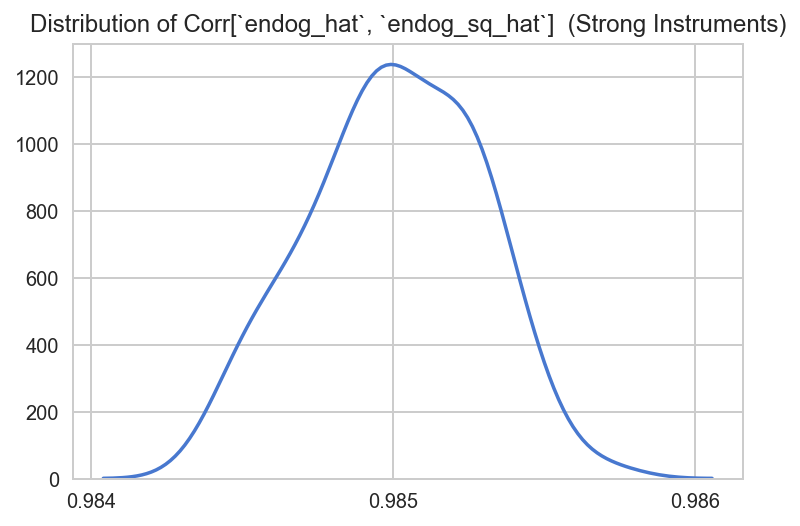

In [5]:
# Plotting the distribution of the correlation between the endog. vars in each pull
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.title('Distribution of Corr[`endog_hat`, `endog_sq_hat`]  (Strong Instruments)')
sns.kdeplot(pearson_correlation).set(xticks=np.unique(np.round(pearson_correlation, 3)));

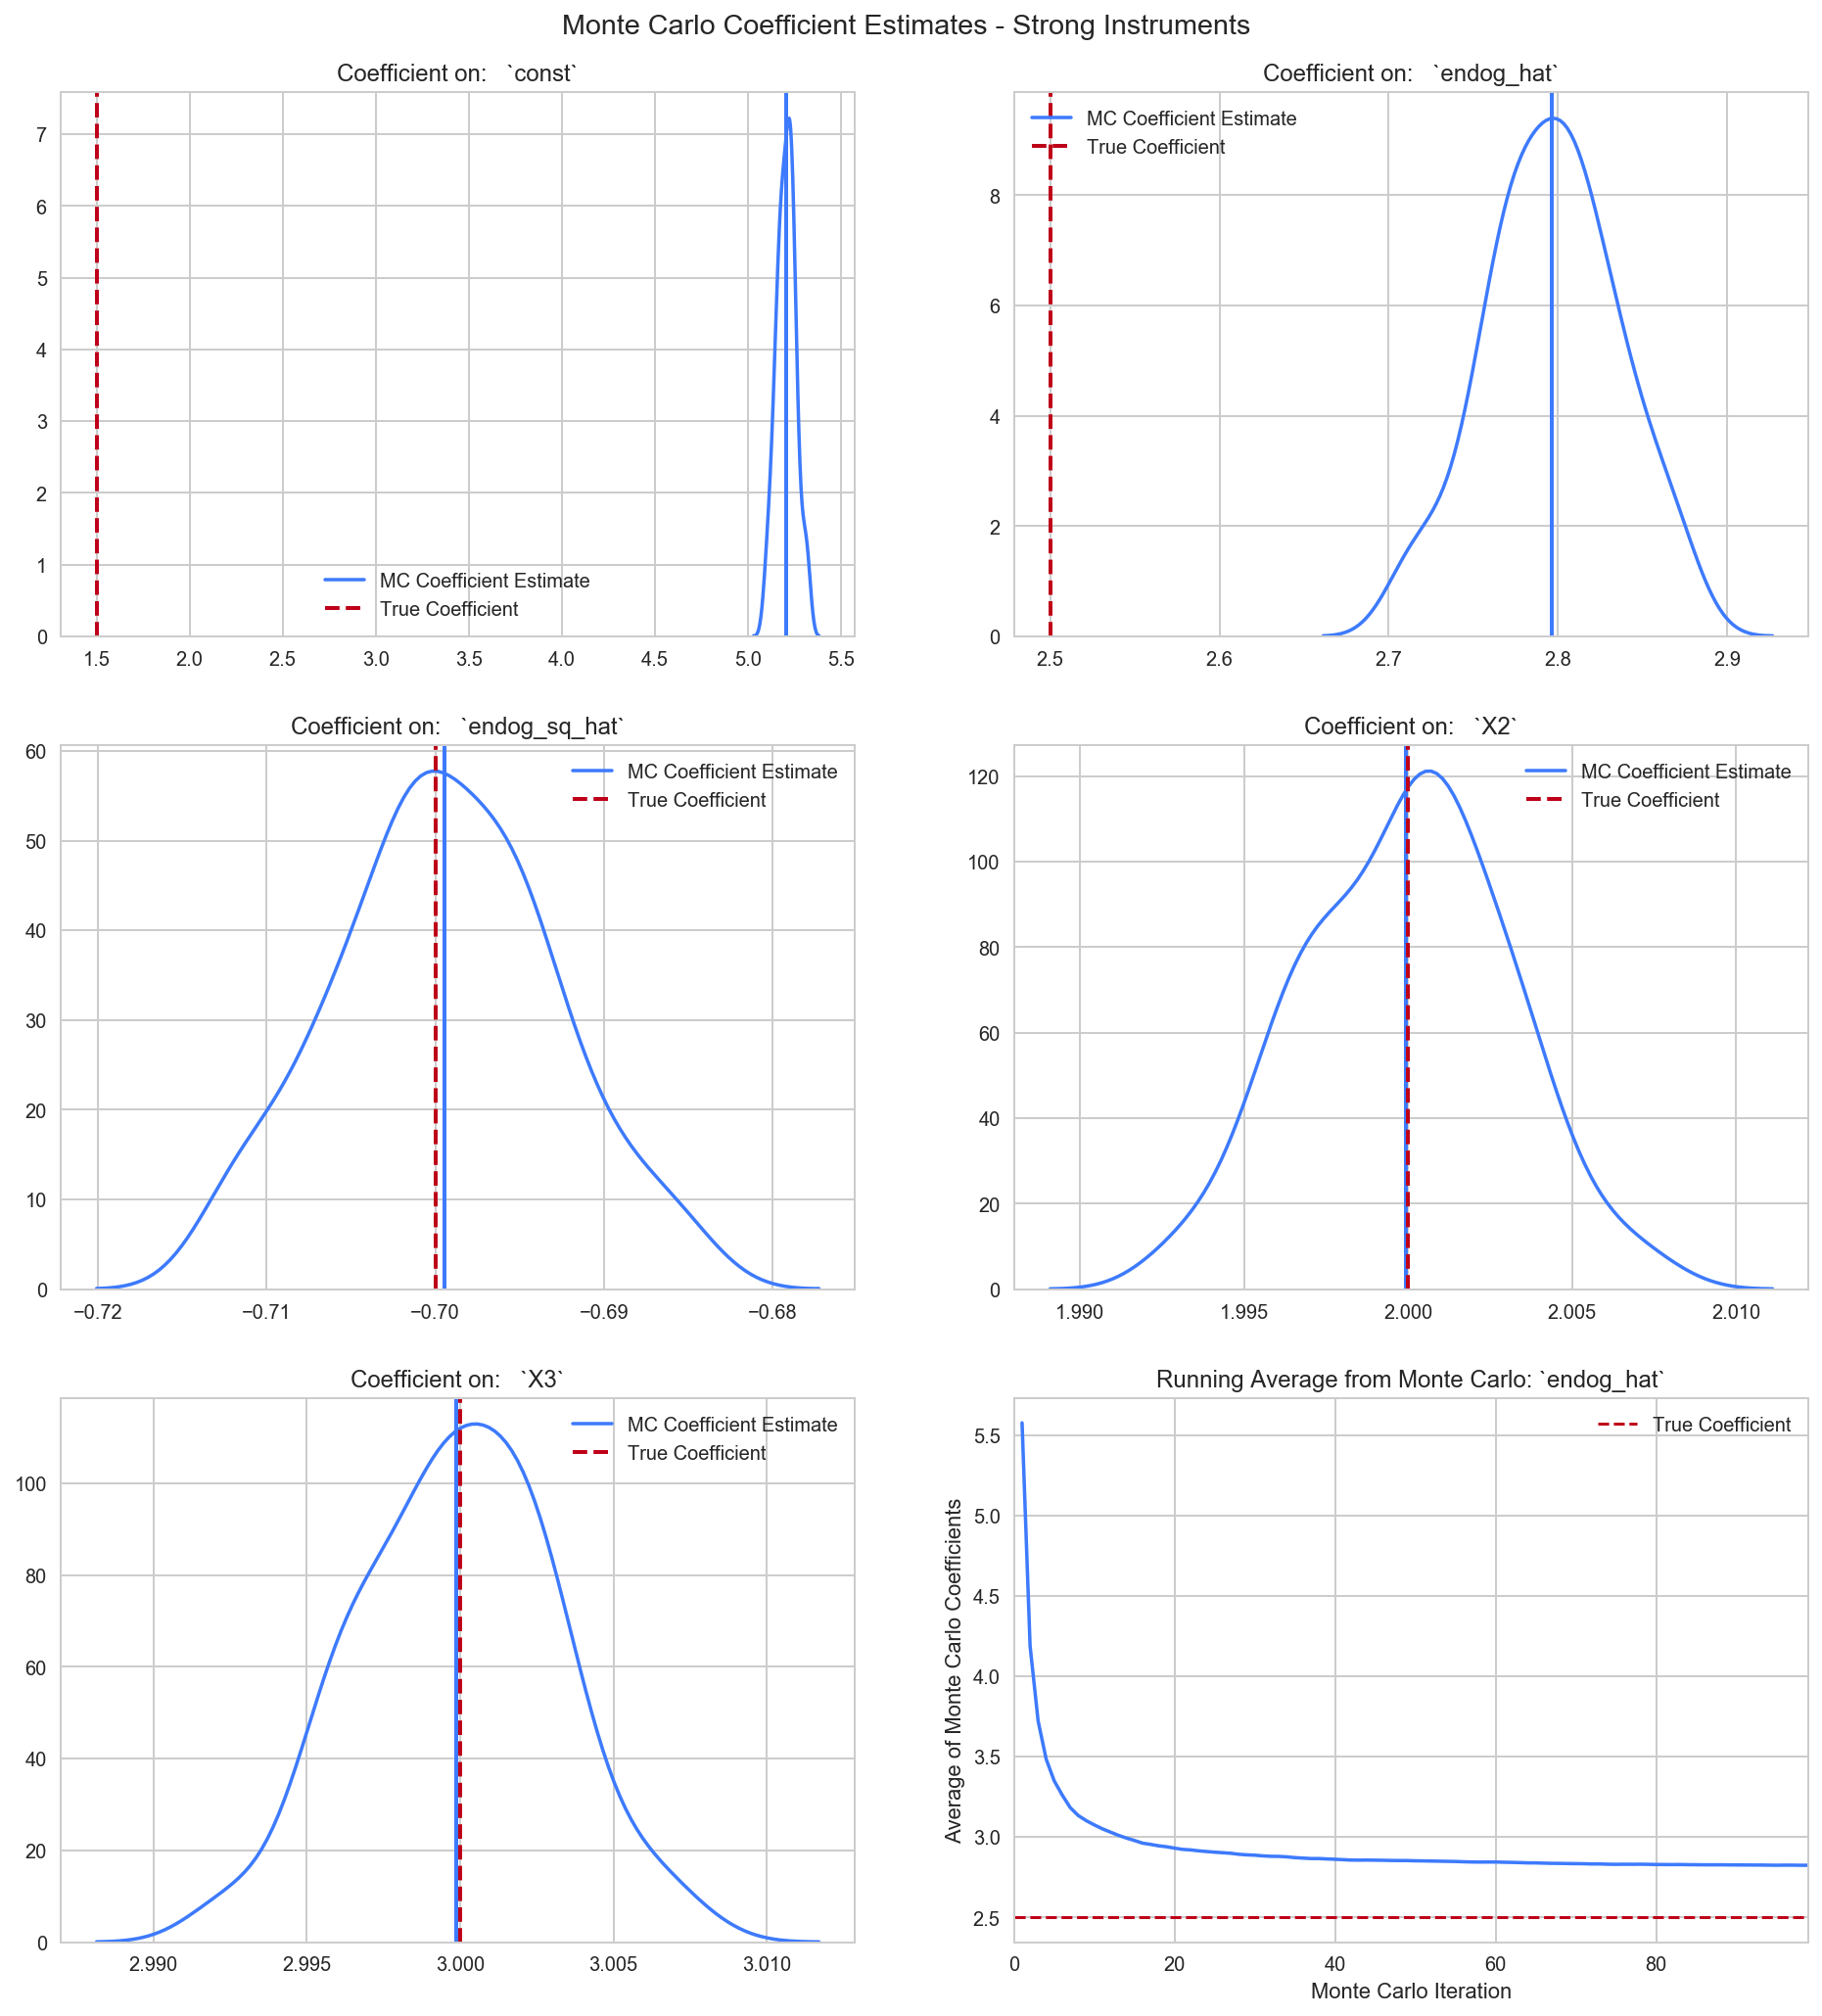

In [6]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff, results_table, add_to_title=' - Strong Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff, 'endog_hat', 1, true_val=2.5, n_boot = n_monte_carlo)
plt.savefig('figures/MC_strong.eps', format='eps', dpi=1200, bbox_inches='tight');

### Strong Instruments - Results I

These results are a bit confusing. Even after playing around with different random seeds, there is some weird stuff going on for all the seeds. It looks like the coefficient estimates are consistent, and that the estimates for the exogenous vars and for $\hat{\mathrm{X}_1^2}$ are unbiased, but that the coefficient estimate on $\hat{\mathrm{X}}_1$ is biased. This behavior is puzzling because the fitted values from the (seemingly) biased Part A are used in the Part B fitting.  

We can also try to visualize the bias as the number of observations increases, this might give us some more intuition on what is going on. In the following analysis we will limit to 50 bootstrap iterations for each sample size (looking at the convergence path for the coefficient on $\hat{\mathrm{X}}_1$ it seems like 50 should be enough), we will save the coefficients of each of these iterations for each sample size for plotting later.

In [7]:
np.random.seed(49067)

n_levels = [1000, 3000, 5000, 10000, 25000, 50000, 100000, 250000, 500000, 625000, 750000]
n_monte_carlo = 50

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.8, 0.6],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.8, 0, 0, 0, 1, 0],
       [0.6, 0, 0, 0, 0, 1]]

### Monte Carlo ###
btsp_coeff  = np.zeros((n_monte_carlo * len(n_levels), 5))
samp_size = np.zeros(n_monte_carlo * len(n_levels))

for n_idx, n in enumerate(tqdm(n_levels)):
    for BB_iter in range(0, n_monte_carlo):
        ## Data Generation ##
        X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

        # Normal, mean zero errors
        epsilon = np.random.normal(0, 1, n)

        # True model:
        Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

        ## Constructing the data sets ##
        # Note: we leave out X4 as the omitted variable from which endogeneity is arising
        exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
        exogenous = sm.add_constant(exogenous)
        endogenous = pd.DataFrame({'X1' : X1})
        #instruments = pd.DataFrame({'Z1' : Z1}) # ----- TESTING WITH ONLY ONE INSTRUMENT --- #
        instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
        Y = pd.DataFrame({'Y' : Y})

        ## Estimating the models ##
        model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
        result1 = model1.fit()

        ## Results ##
        btsp_coeff[n_idx*n_monte_carlo + BB_iter] = result1.result2.params
        samp_size[n_idx*n_monte_carlo + BB_iter] = n

100%|██████████| 11/11 [03:10<00:00, 17.32s/it]


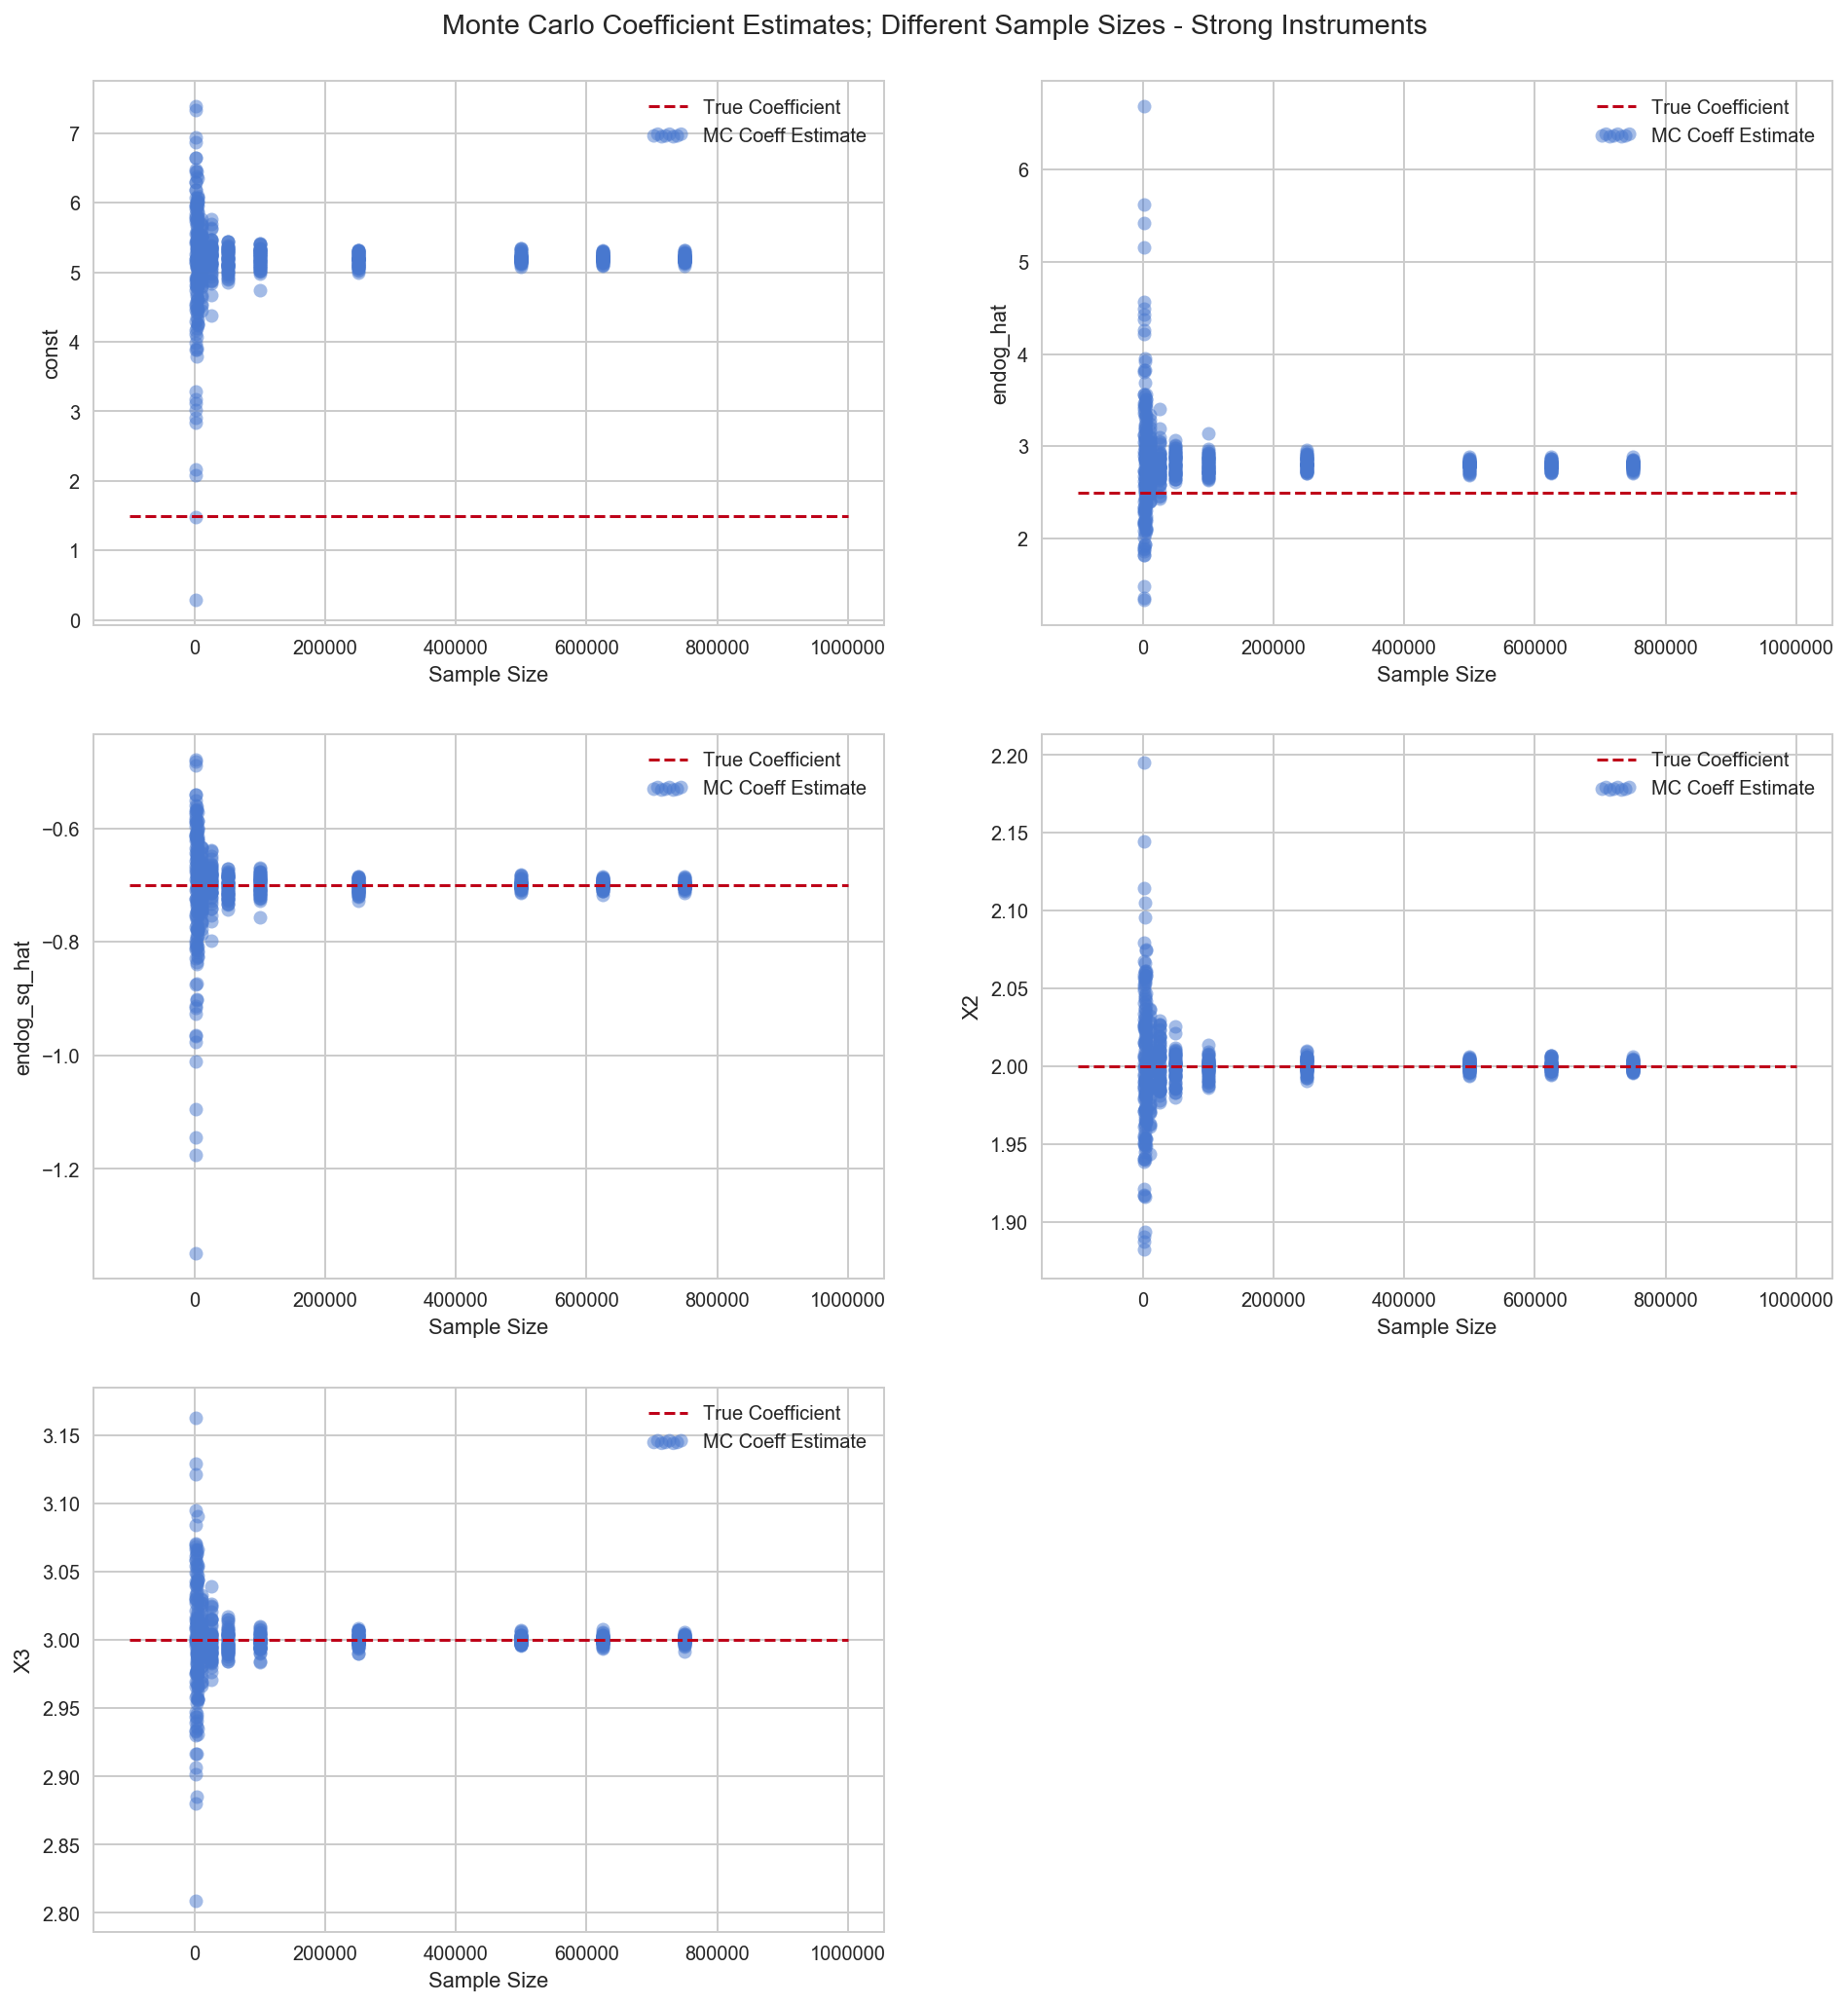

In [8]:
# Formatting results
coeffs_samp_size_strong = pd.DataFrame(btsp_coeff, columns = ['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3'])
coeffs_samp_size_strong.insert(0, 'n_obs', samp_size.astype(int))
true_coeffs = [1.5, 2.5, -0.7, 2, 3]

# Plotting
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.95)
plt.suptitle('Monte Carlo Coefficient Estimates; Different Sample Sizes - Strong Instruments')

sns.despine()
for column_index, column in enumerate(coeffs_samp_size_strong.columns.tolist()[1:]):
    plt.subplot(3, 2, column_index + 1)
    sns.regplot(x='n_obs', y=column, data=coeffs_samp_size_strong, fit_reg = False, scatter_kws={'alpha':0.5}, label = 'MC Coeff Estimate')
    plt.plot([-100000, 1000000], 
             [true_coeffs[column_index], true_coeffs[column_index]], 
             linewidth=1.5,
             linestyle = '--', 
             color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
    plt.xlabel('Sample Size')
    plt.legend(scatterpoints=8)
plt.savefig('figures/MC_strong_sizes.eps', format='eps', dpi=1200, bbox_inches='tight');    

### Strong Instruments - Results II

We find the same funky behavior in this simulation. This is not surprising (this is an extension of the original approach but with multiple sample sizes and no averaging), but it does support the same unusual conclusion we came to originally. This is something that needs to be considered more closely, as it is not immediately clear where the bias is coming from on the (1'st stage Part A estimated) endogenous variable's coefficient, and why this bias isn't affecting the coefficient on the (1'st stage Part B estimated) square of the endogenous variable.

# Weak Instruments

The only change to the DGP here is the covariance between the endogenous variable and the instruments:
$$
\begin{align*}
\begin{pmatrix}
  \mathrm{X}_{1, i}\\
  \mathrm{X}_{2, i}\\
  \mathrm{X}_{3, i}\\
  \mathrm{X}_{4, i}\\
  \mathrm{Z}_{1, i}\\
  \mathrm{Z}_{2, i}
\end{pmatrix} \ &\sim \ N
\begin{bmatrix}
\begin{pmatrix}
  3\\
  -1.5\\
  1.1\\
  2.3\\
  -1\\
  3
\end{pmatrix} \ , \
\begin{pmatrix}
    1 & 0 & 0 & 0.75 & 0.25 & 0.2 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0.75 & 0 & 0 & 1 & 0 & 0 \\
    0.25 & 0 & 0 & 0 & 1 & 0 \\
    0.2 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{bmatrix} \\
\\
\varepsilon_i \ &\sim  \ N(0, 1) \\
\\
\mathrm{Y}_i &= 1.5 + 2.5 \cdot \mathrm{X}_{1, i} - 0.7 \cdot \mathrm{X}_{1, i}^2 + 2 \cdot \mathrm{X}_{2, i} + 3 \cdot \mathrm{X}_{3, i} + 2 \cdot \mathrm{X}_{4, i} + \varepsilon_i
\end{align*}
$$

In [9]:
np.random.seed(49067)

n = 500000
n_monte_carlo = 100

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]


### Monte Carlo ###
full_sample_btsp_coeff2  = np.zeros((n_monte_carlo, 5))
pearson_correlation2     = np.zeros(n_monte_carlo)

for BB_iter in tqdm(range(0, n_monte_carlo)):
    ## Data Generation ##
    X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

    # Normal, mean zero errors
    epsilon = np.random.normal(0, 1, n)

    # True model:
    Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

    ## Constructing the data sets ##
    # Note: we leave out X4 as the omitted variable from which endogeneity is arising
    exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
    exogenous = sm.add_constant(exogenous)
    endogenous = pd.DataFrame({'X1' : X1})
    #instruments = pd.DataFrame({'Z1' : Z1}) # ----- TESTING WITH ONLY ONE INSTRUMENT --- #
    instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
    Y = pd.DataFrame({'Y' : Y})

    ## Estimating the models ##
    model2 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
    result2 = model2.fit()

    ## Results ##
    full_sample_btsp_coeff2[BB_iter] = result2.result2.params
    pearson_correlation2[BB_iter]    = pearsonr(result2.result1A.fittedvalues, result2.result1B.fittedvalues)[0]

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [10]:
results_table2 = results_df3(full_sample_btsp_coeff2, true_coeffs = [1.5, 2.5, -0.7, 2, 3])
results_table2

,True_Coeffs,Full_Sample_Bootstrap
const,1.5,6.040124
endog_hat,2.5,2.546268
endog_sq_hat,-0.7,-0.707850
X2,2.0,1.999733
X3,3.0,2.999686


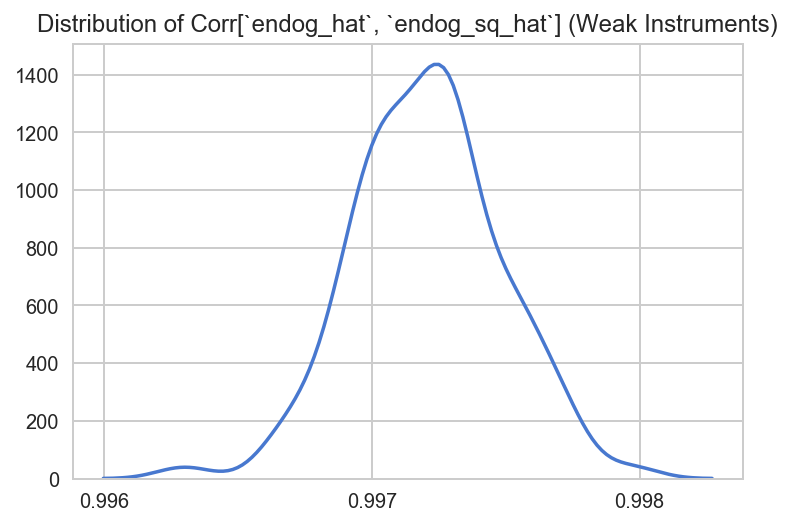

In [11]:
# Plotting the distribution of the correlation between the endog. vars in each pull
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.title('Distribution of Corr[`endog_hat`, `endog_sq_hat`] (Weak Instruments)')
sns.kdeplot(pearson_correlation2).set(xticks=np.unique(np.round(pearson_correlation2, 3)));

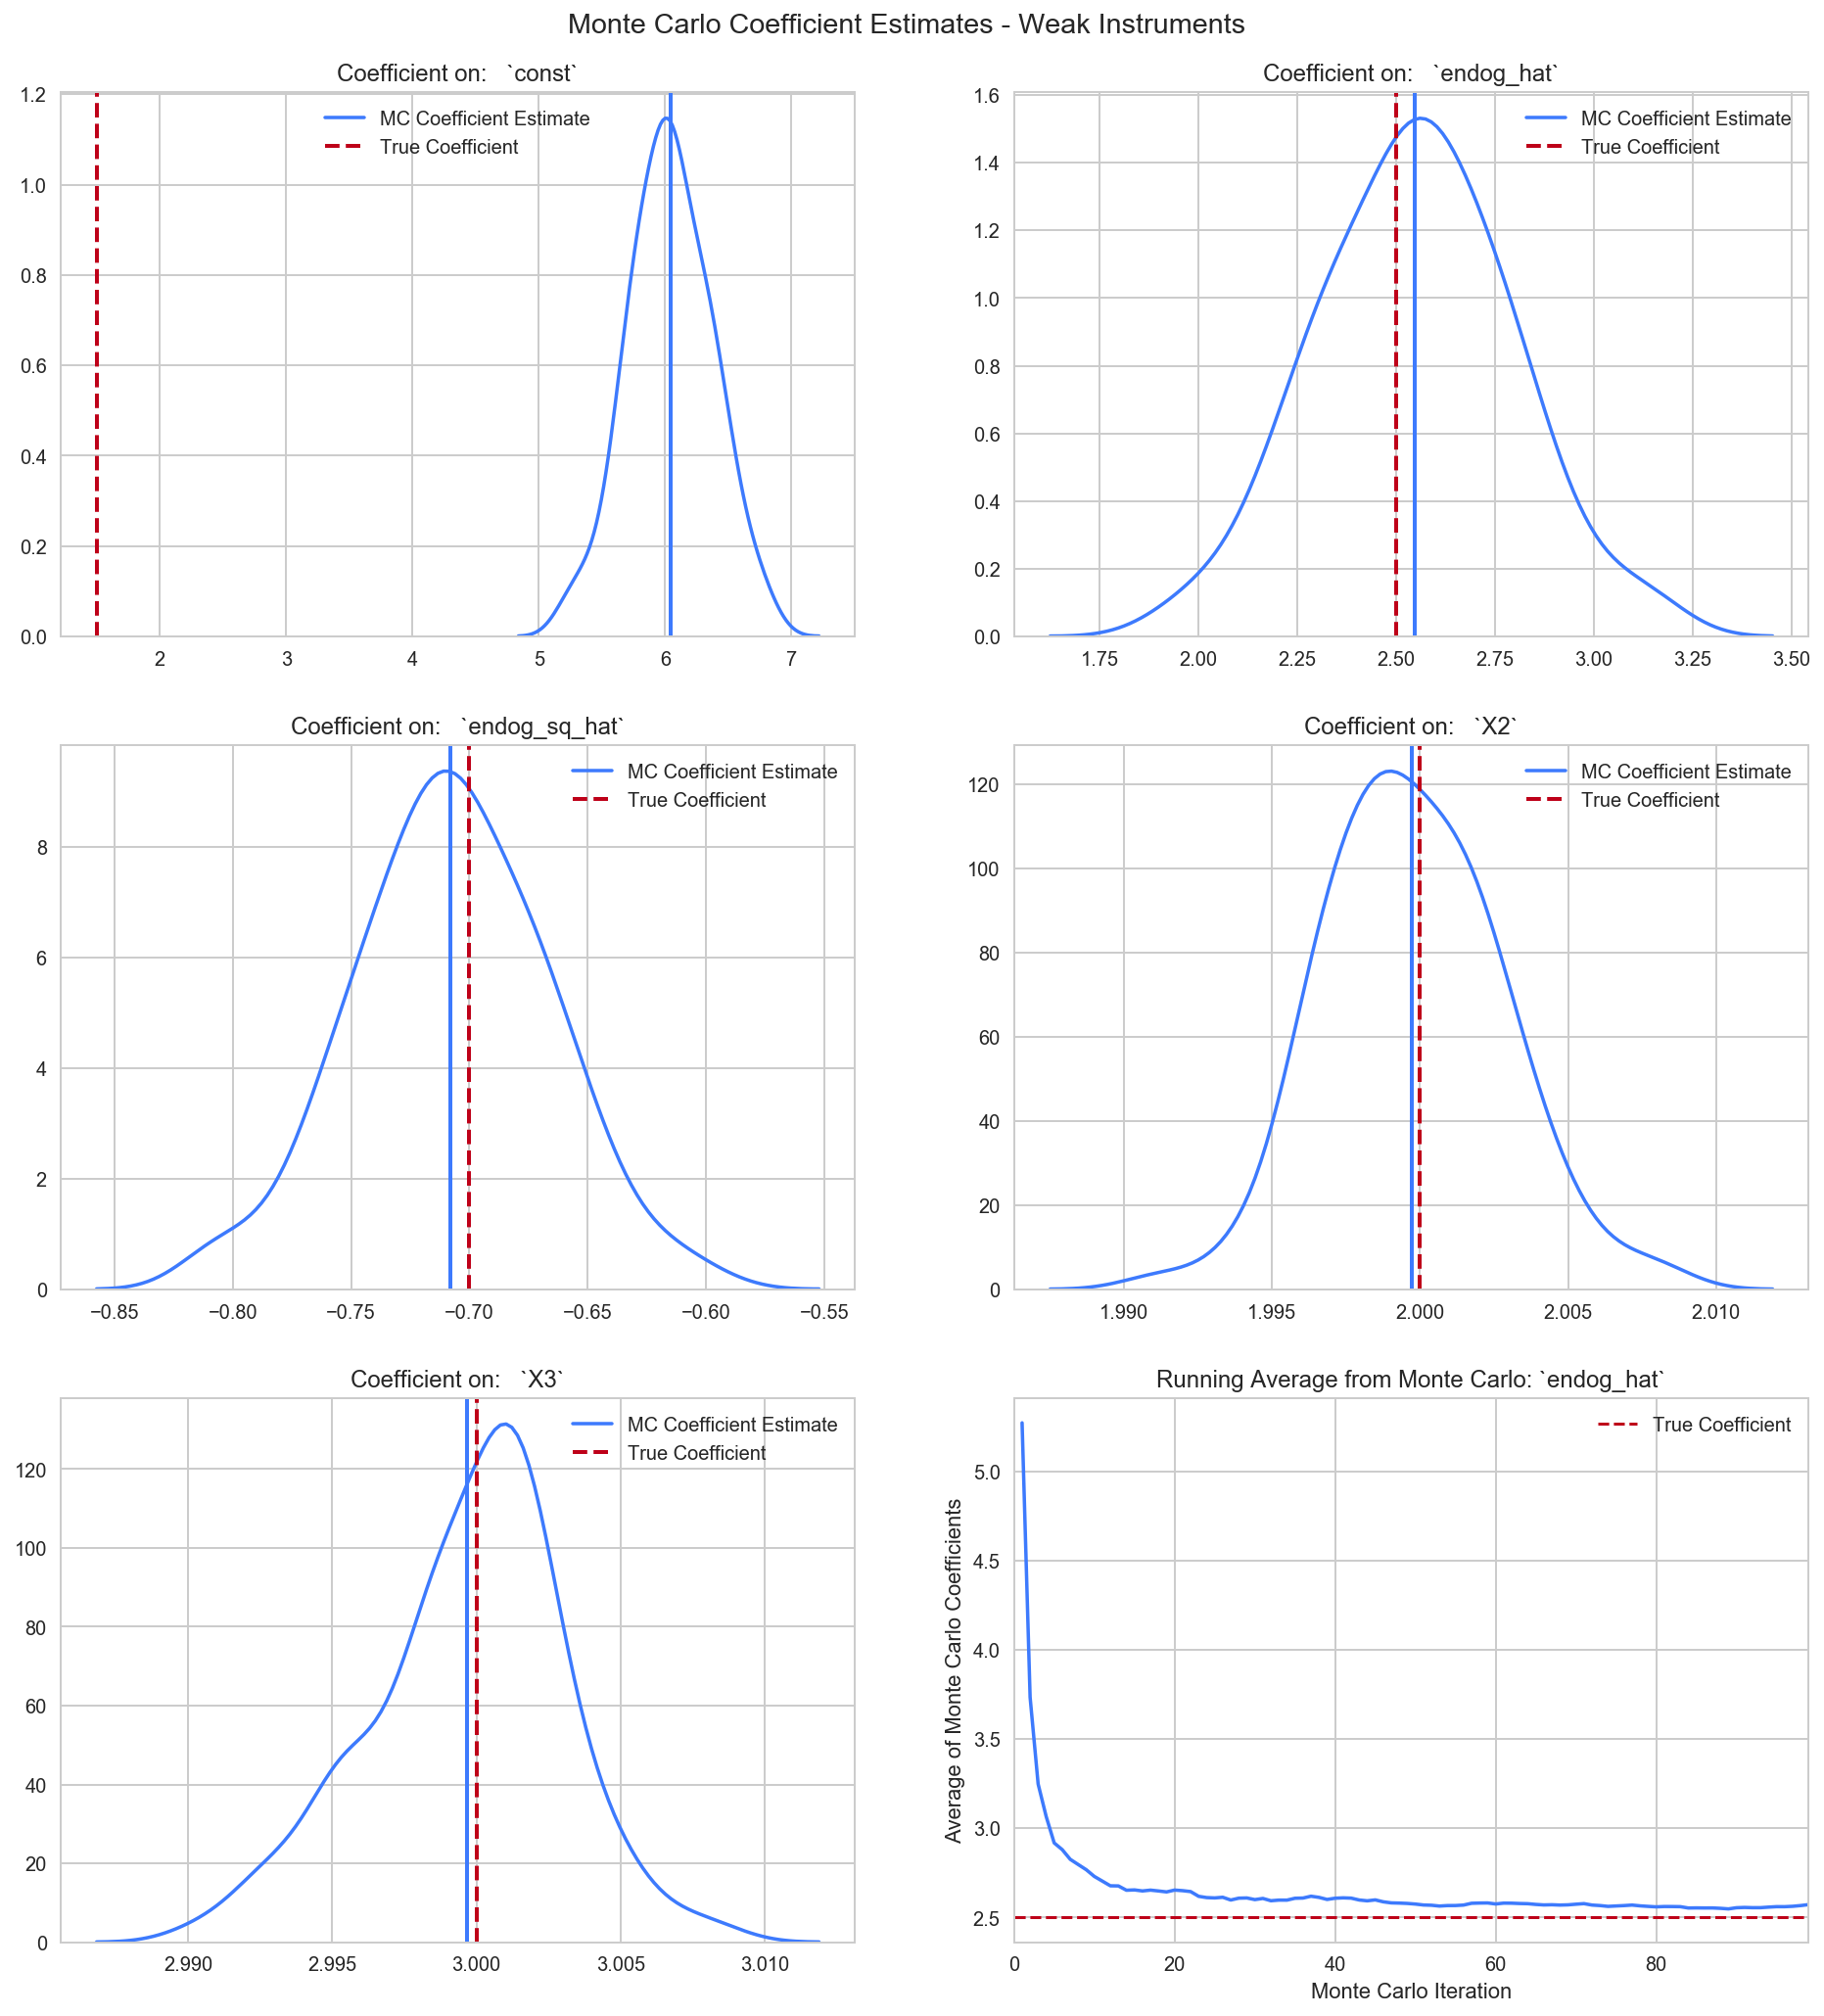

In [12]:
# Full Sample Bootstrap Distributions
custom_dist_plots3(full_sample_btsp_coeff2, results_table2, add_to_title=' - Weak Instruments')
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff2, 'endog_hat', 1, 2.5, n_monte_carlo)
plt.savefig('figures/MC_weak.eps', format='eps', dpi=1200, bbox_inches='tight');

### Weak Instruments - Results I

As expected, the coefficient estimates under weak instruments have far larger variance.  

Interestingly though it seems like the coefficient estimate for $\hat{\mathrm{X}}_1$ might be less biased than they were in the strong instruments set up. This is very unexpected, it seems counterintuitive that weaker instruments would decrease the bias on the endogenous variable. Although since we don't yet understand where the bias is coming from, intuition is probably not all that helpful here.  

Below we run the same analysis as we did for the strong instruments to see how the estimates vary with sample size.

In [13]:
np.random.seed(49067)

n_levels = [1000, 3000, 5000, 10000, 25000, 50000, 100000, 250000, 500000, 625000, 750000]
n_monte_carlo = 50

## DGP ##
means = [3, -1.5, 1.1, 2.3, -1, 3]
cov = [[1, 0, 0, 0.75, 0.25, 0.2],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0.75, 0, 0, 1, 0, 0],
       [0.25, 0, 0, 0, 1, 0],
       [0.2, 0, 0, 0, 0, 1]]

### Monte Carlo ###
btsp_coeff2  = np.zeros((n_monte_carlo * len(n_levels), 5))
samp_size2 = np.zeros(n_monte_carlo * len(n_levels))

for n_idx, n in enumerate(tqdm(n_levels)):
    for BB_iter in range(0, n_monte_carlo):
        ## Data Generation ##
        X1, X2, X3, X4, Z1, Z2 = np.random.multivariate_normal(means, cov, n).T

        # Normal, mean zero errors
        epsilon = np.random.normal(0, 1, n)

        # True model:
        Y = 1.5 + 2.5*X1 - 0.7*(X1)**2 + 2*X2 + 3*X3 + 2*X4 + epsilon

        ## Constructing the data sets ##
        # Note: we leave out X4 as the omitted variable from which endogeneity is arising
        exogenous = pd.DataFrame({'X2' : X2, 'X3' : X3})
        exogenous = sm.add_constant(exogenous)
        endogenous = pd.DataFrame({'X1' : X1})
        #instruments = pd.DataFrame({'Z1' : Z1}) # ----- TESTING WITH ONLY ONE INSTRUMENT --- #
        instruments = pd.DataFrame({'Z1' : Z1, 'Z2' : Z2})
        Y = pd.DataFrame({'Y' : Y})

        ## Estimating the models ##
        model1 = q2sls.Quadratic2SLS(Y, exogenous, endogenous, instruments)
        result1 = model1.fit()

        ## Results ##
        btsp_coeff2[n_idx*n_monte_carlo + BB_iter] = result1.result2.params
        samp_size2[n_idx*n_monte_carlo + BB_iter] = n

100%|██████████| 11/11 [02:48<00:00, 15.33s/it]


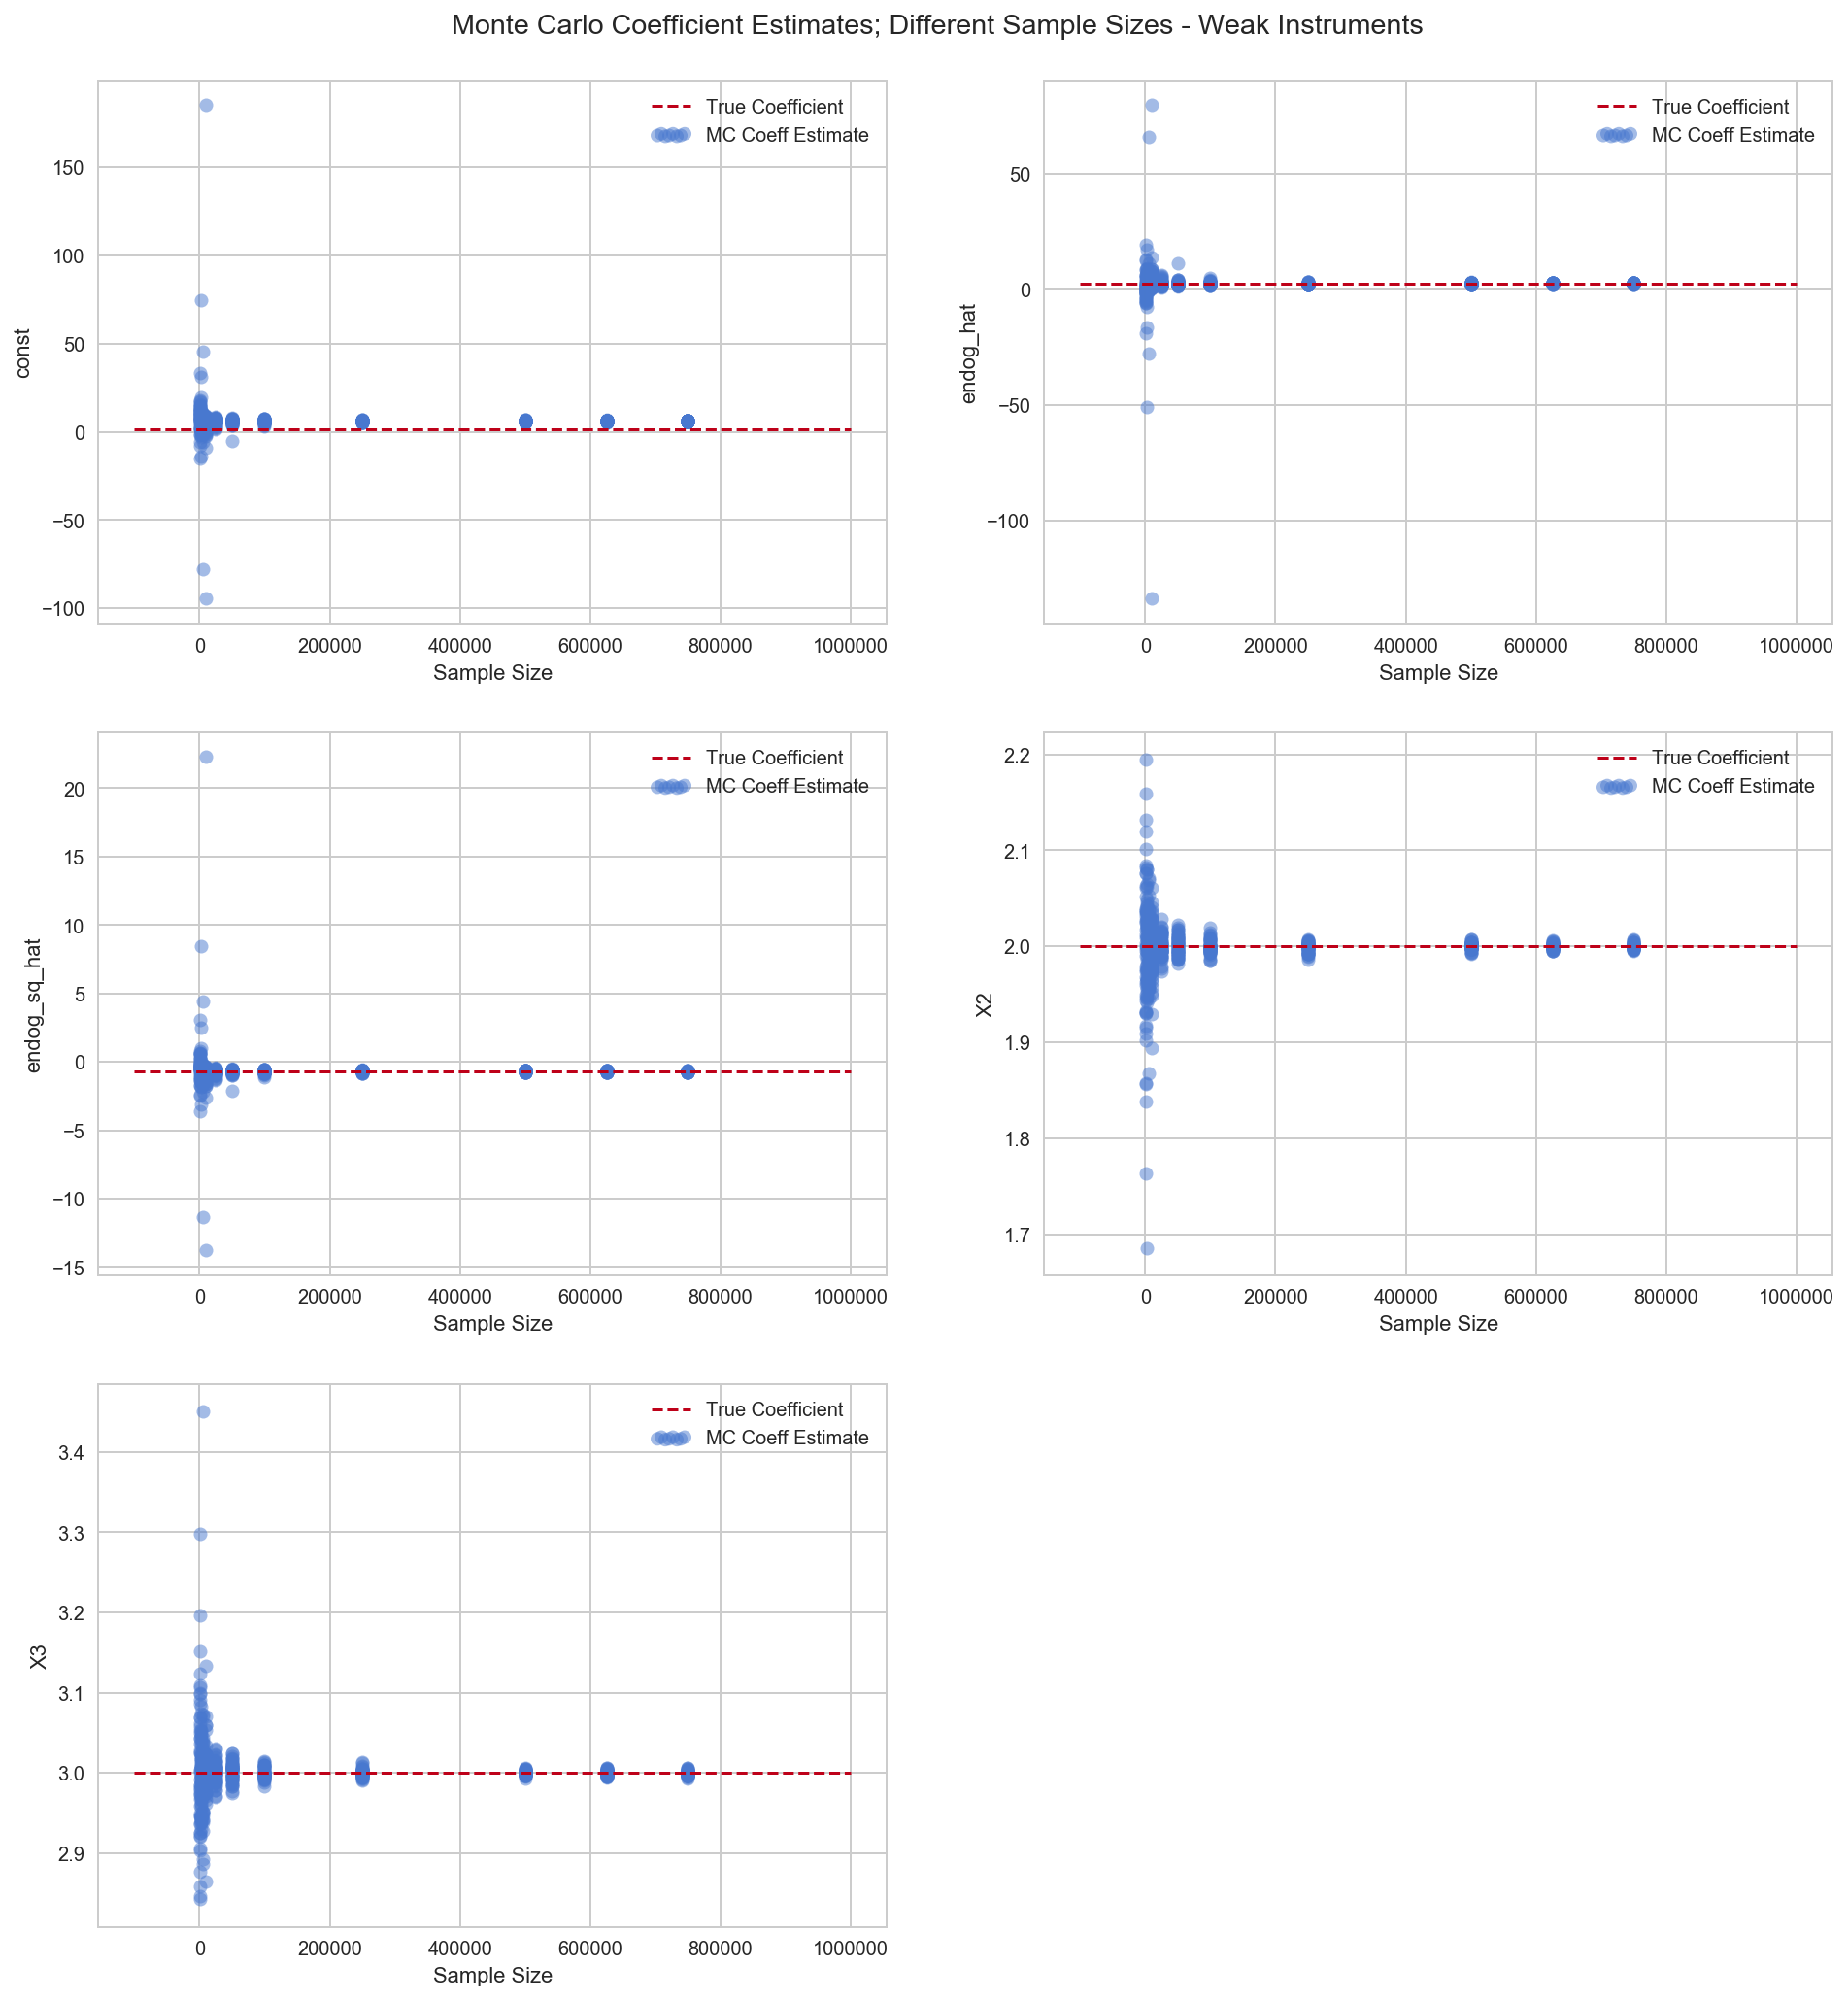

In [14]:
# Formatting results
coeffs_samp_size_weak = pd.DataFrame(btsp_coeff2, columns = ['const', 'endog_hat', 'endog_sq_hat', 'X2', 'X3'])
coeffs_samp_size_weak.insert(0, 'n_obs', samp_size2.astype(int))
true_coeffs = [1.5, 2.5, -0.7, 2, 3]

# Plotting
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)

plt.subplots_adjust(top=0.95)
plt.suptitle('Monte Carlo Coefficient Estimates; Different Sample Sizes - Weak Instruments')

sns.despine()
for column_index, column in enumerate(coeffs_samp_size_weak.columns.tolist()[1:]):
    plt.subplot(3, 2, column_index + 1)
    sns.regplot(x='n_obs', y=column, data=coeffs_samp_size_weak, fit_reg = False, scatter_kws={'alpha':0.5}, label = 'MC Coeff Estimate')
    plt.plot([-100000, 1000000], 
             [true_coeffs[column_index], true_coeffs[column_index]], 
             linewidth=1.5,
             linestyle = '--', 
             color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
    plt.xlabel('Sample Size')
    plt.legend(scatterpoints=8)
plt.savefig('figures/MC_weak_sizes.eps', format='eps', dpi=1200, bbox_inches='tight');    

### Weak Instruments - Results II

The variance is too high in the weak instruments setting to easily compare across the graphs of the weak and strong distributions. Below we plot the results on the same plot to allow comparison.  

## Comparing Strong and Weak Instruments

We combine the results above and present them in the same plots for comparison.

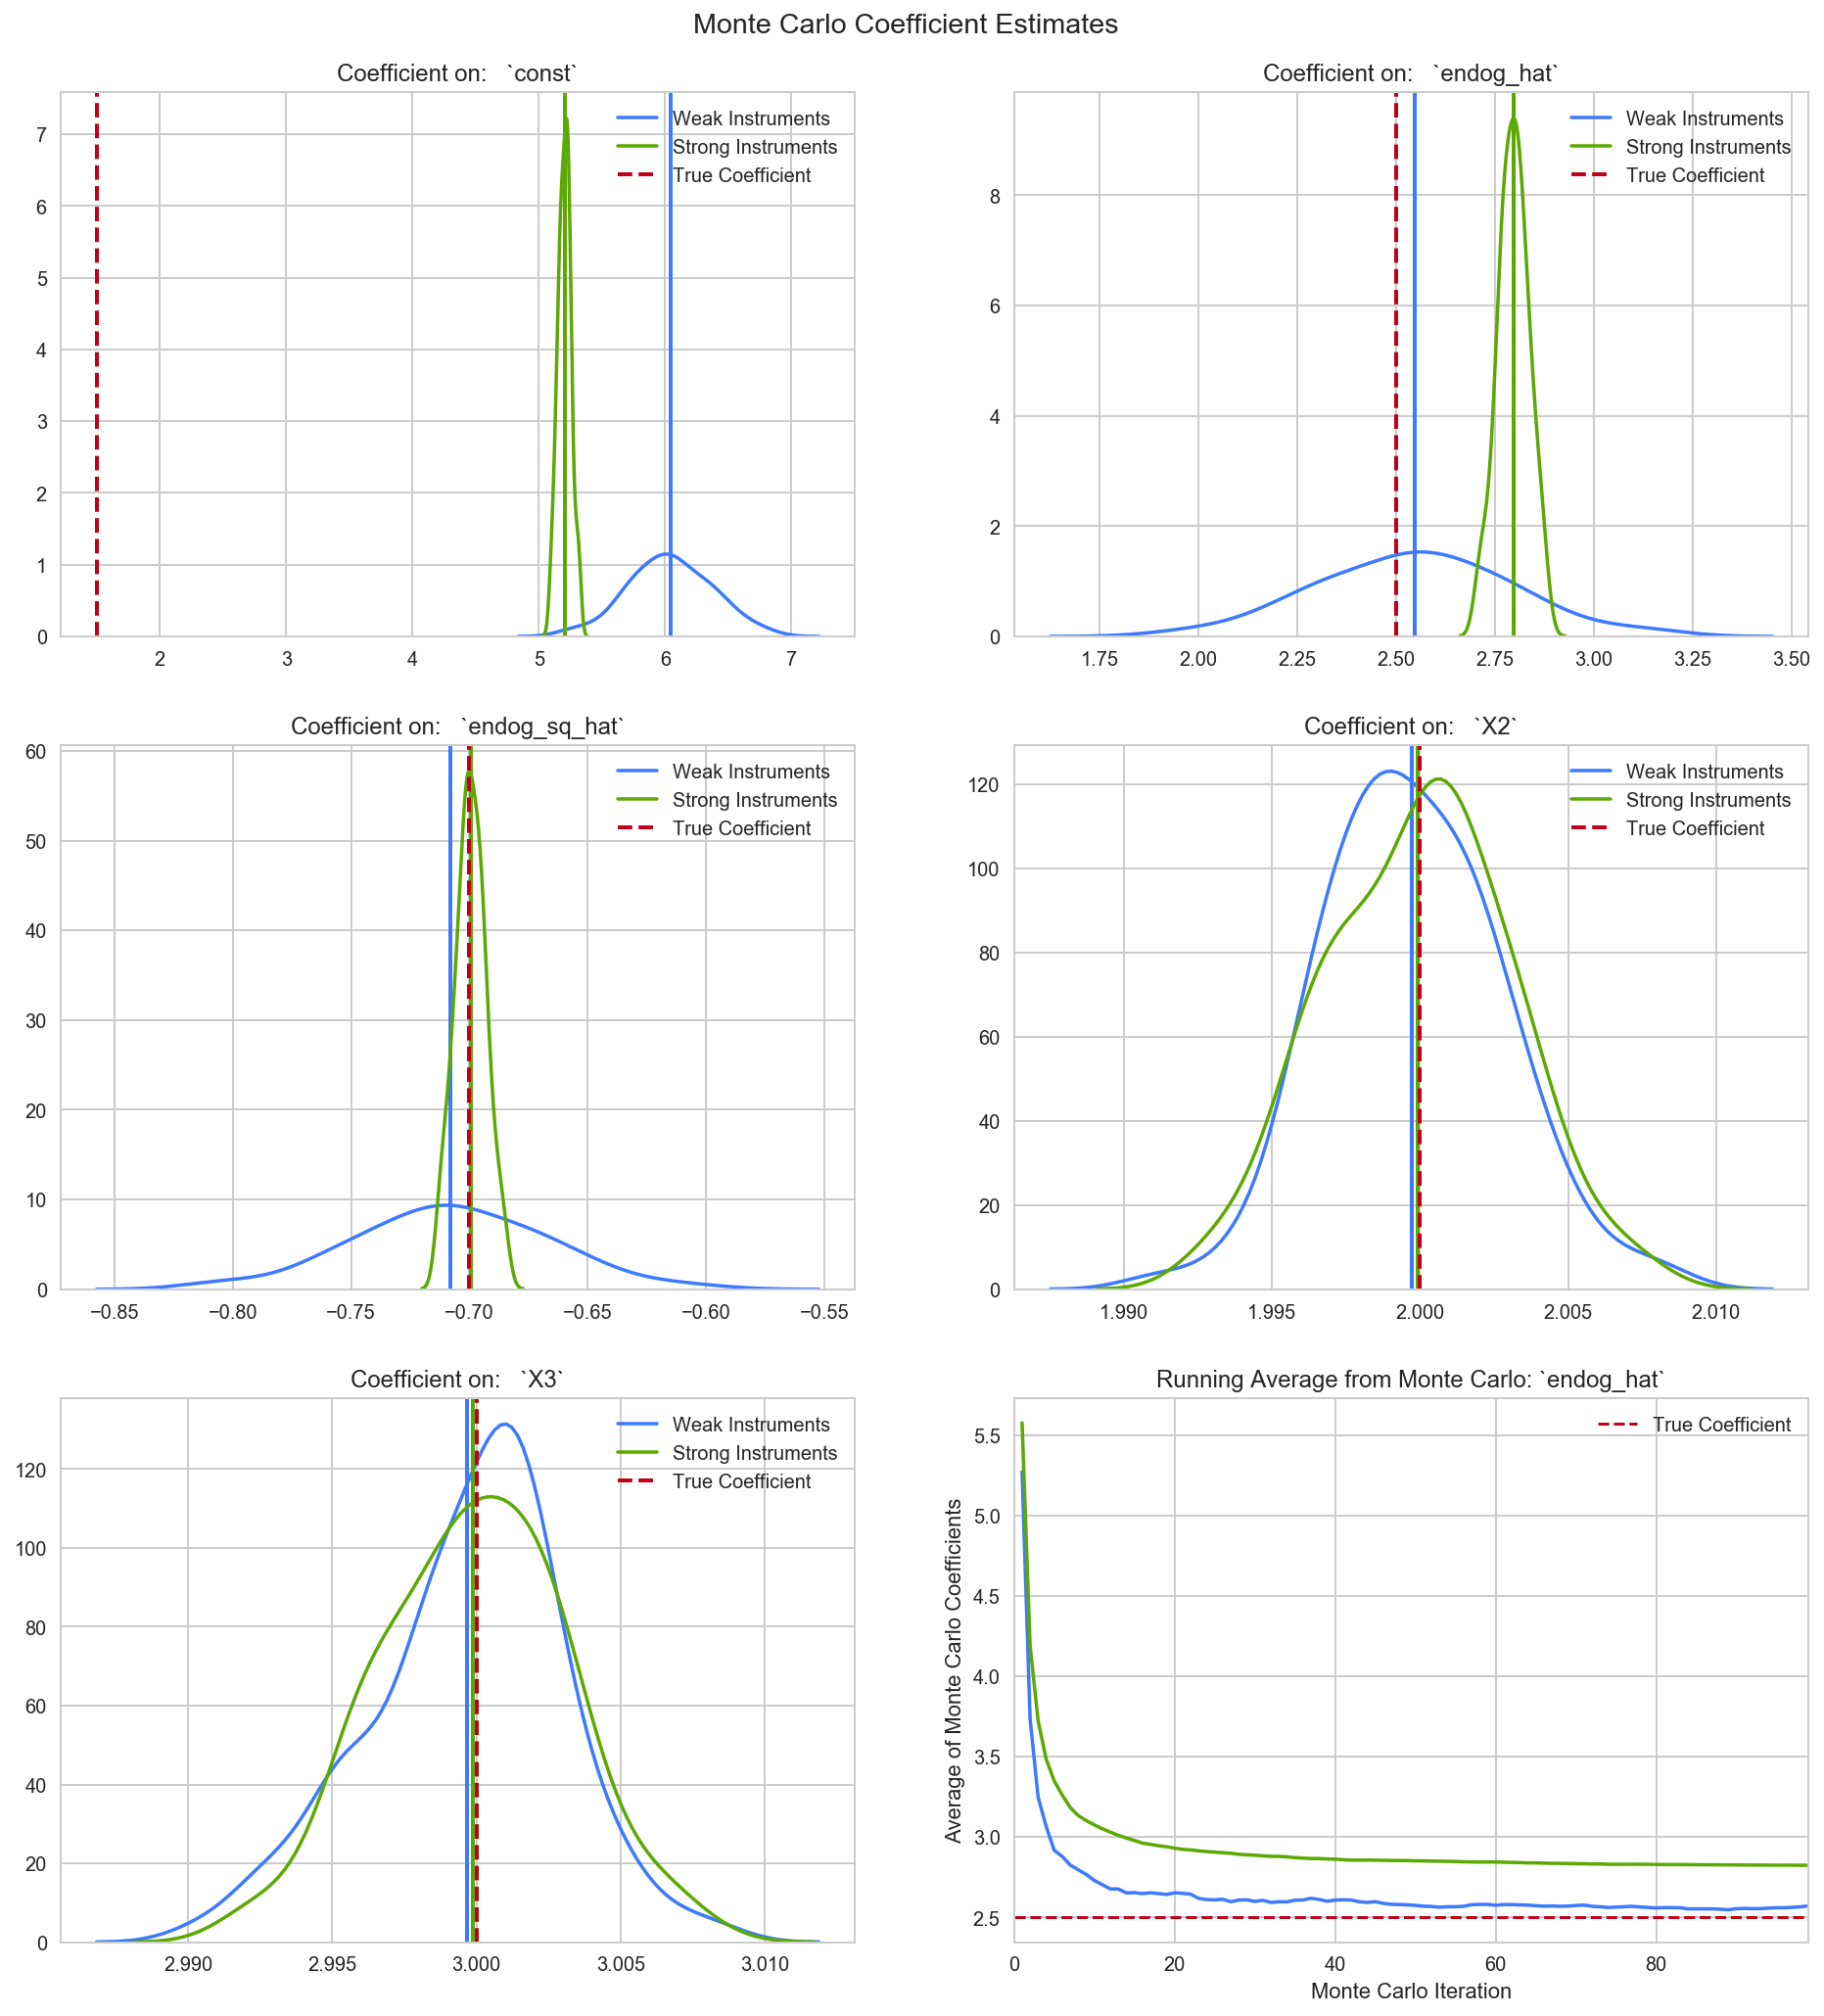

In [15]:
# Full Sample Monte Carlo Distributions
custom_dist_plots3(full_sample_btsp_coeff2, results_table2, add_to_title='', 
                   big_bootstrap_res2=full_sample_btsp_coeff, results_table_out2=results_table)
# Coefficient Path
plt.subplot(3, 2, 6)
coeff_path_plot2(full_sample_btsp_coeff2, 'endog_hat', 1, true_val = 2.5, n_boot = 100, big_bootstrap_res2=full_sample_btsp_coeff);
plt.savefig('figures/MC_strong_and_weak.eps', format='eps', dpi=1200, bbox_inches='tight');

### Instruments Comparison - Results I

We see that coefficient estimates for the exogenous variables is fairly similar for strong and weak instruments. The variance of the coefficients on the endogenous variables is larger for the weak instruments (as expected). However, the coefficient estimate on $\hat{\mathrm{X}}_1$ does indeed seem to be less biased for the weak instruments. The coefficient estimate on $\hat{\mathrm{X}_1^2}$ might be more biased for the weak instruments, but it's hard to tell with such a wide variance and close mean. It is still unclear why the model is behaving in this strange way. In the strong instruments setting, the bias that we see in the coefficient on $\hat{\mathrm{X}}_1$ should intuitively be even worse for the coefficient on $\hat{\mathrm{X}_1^2}$ because $\hat{\mathrm{X}_1^2}$ is constructed using $(\hat{\mathrm{X}}_1)^2$, which seems like it would increase the bias we see in $\hat{\mathrm{X}}_1$.

Below we continue the analysis, as before.  
*Note: We limit the y-axis (to better see the variability in the large sample estimates), so the plots will not include all observations for the smaller sample sizes.*

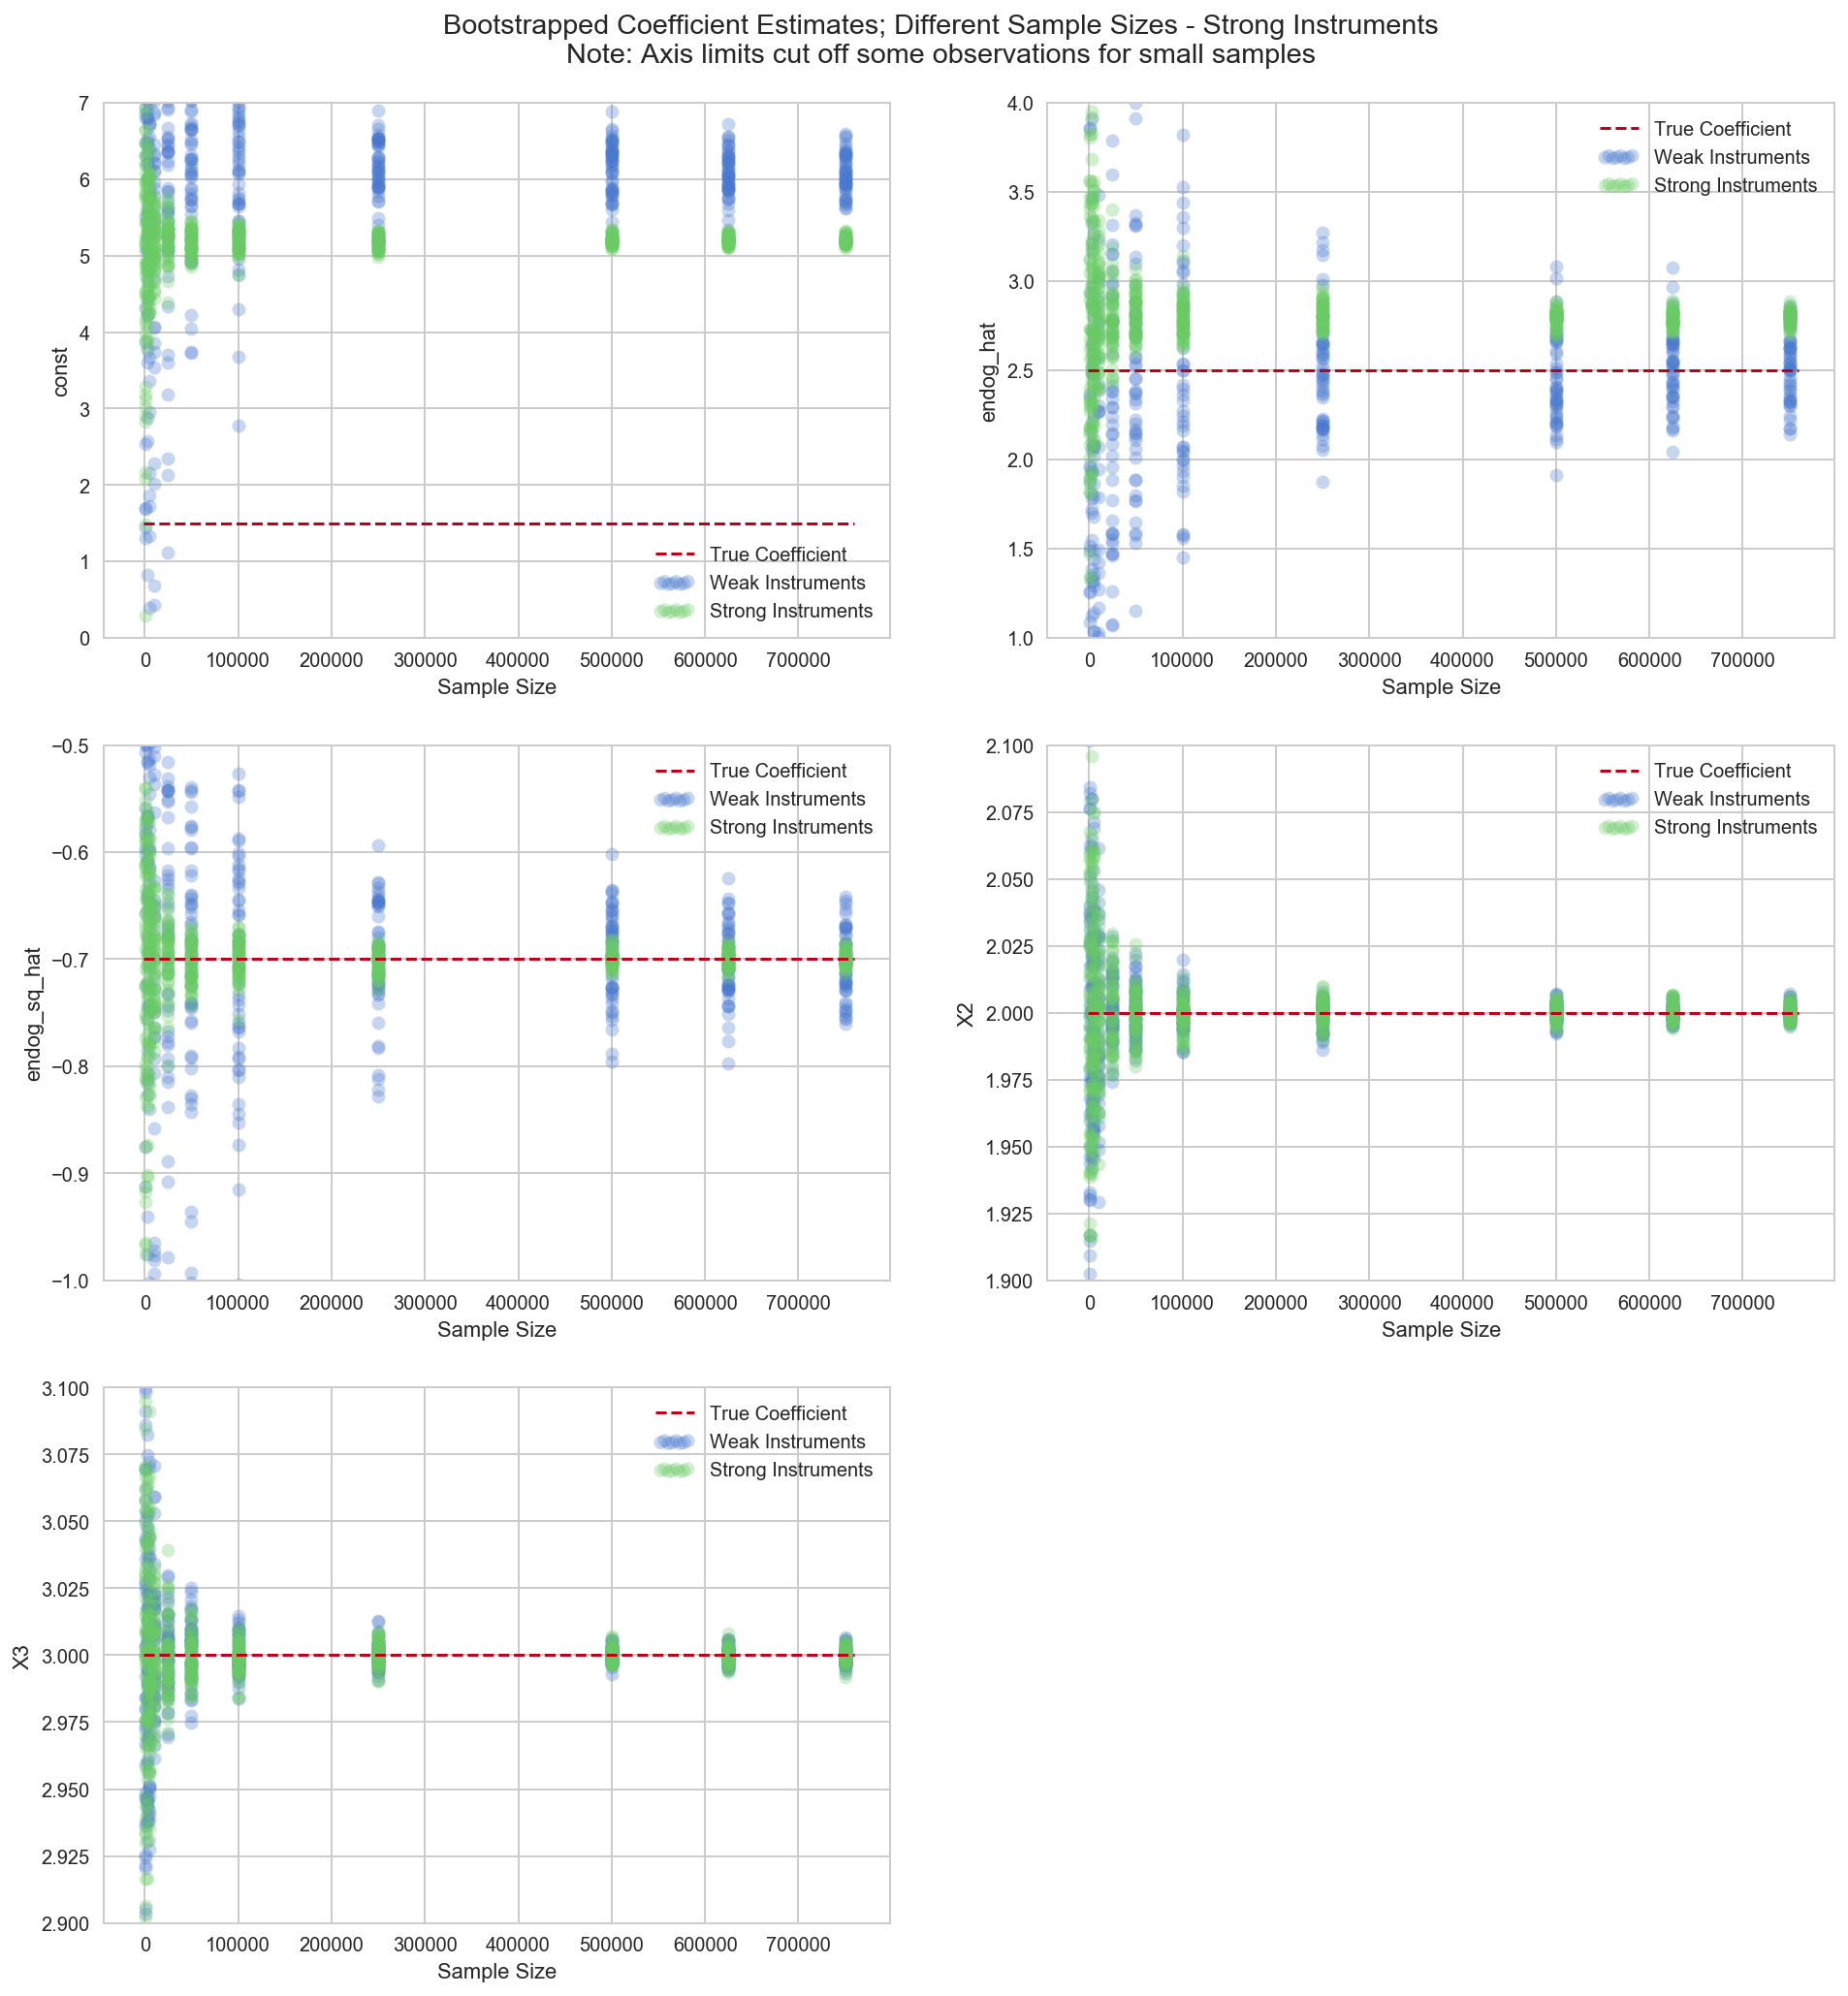

In [16]:
# Setting custom axis limits
low_range = [0, 1, -1, 1.9, 2.9]
upper_range = [7, 4, -0.5, 2.1, 3.1]

# Plotting
plt.figure(figsize=(16, 16))
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.subplots_adjust(top=0.94)
plt.suptitle('Bootstrapped Coefficient Estimates; Different Sample Sizes - Strong Instruments' + 
             '\nNote: Axis limits cut off some observations for small samples')
sns.despine()
for column_index, column in enumerate(coeffs_samp_size_strong.columns.tolist()[1:]):
    plt.subplot(3, 2, column_index + 1)
    sns.regplot(x='n_obs', y=column, data = coeffs_samp_size_weak, 
                fit_reg = False, scatter_kws={'alpha':0.3}, label = 'Weak Instruments').set_ylim(low_range[column_index], upper_range[column_index])
    sns.regplot(x='n_obs', y=column, data = coeffs_samp_size_strong, 
                fit_reg = False, scatter_kws={'alpha':0.3}, label = 'Strong Instruments').set_ylim(low_range[column_index], upper_range[column_index])
    plt.plot([-1000, 760000],#[-100000, 1000000], 
             [true_coeffs[column_index], true_coeffs[column_index]], 
             linewidth=1.5, linestyle = '--', 
             color = sns.xkcd_rgb['scarlet'], label = 'True Coefficient')
    plt.xlabel('Sample Size')
    plt.legend(scatterpoints = 8)
plt.savefig('figures/MC_strong_and_weak_sizes.eps', format='eps', dpi=1200, bbox_inches='tight');    

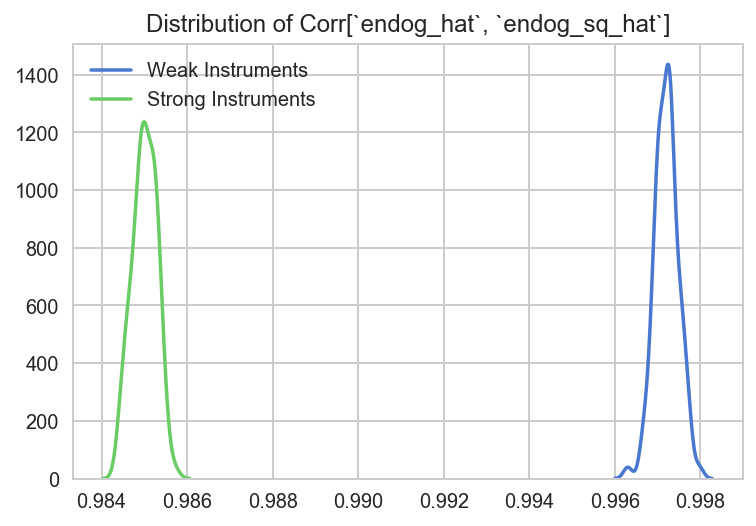

In [17]:
# Plotting the distribution of the correlation between the endog. vars in each pull
sns.set(style="whitegrid", palette="muted", color_codes=True)
plt.title('Distribution of Corr[`endog_hat`, `endog_sq_hat`]')
sns.kdeplot(pearson_correlation2, label = 'Weak Instruments')
sns.kdeplot(pearson_correlation, label = 'Strong Instruments');
plt.savefig('figures/MC_strong_and_weak_corr.eps', format='eps', dpi=1200, bbox_inches='tight');